In [1]:
#! pip install captcha

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from keras.utils.np_utils import to_categorical

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## A generator to randomly generate a batch of captchas

In [3]:
characters = string.digits + string.ascii_uppercase
width, height, n_len, n_class = 170, 80, 4, len(characters)

def gen(batch_size=16):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y
        

def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])


## Construct the deep neural network architecture

In [4]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
             optimizer='adadelta',
             metrics=['accuracy'])

## Visualize the deep neural network architecture

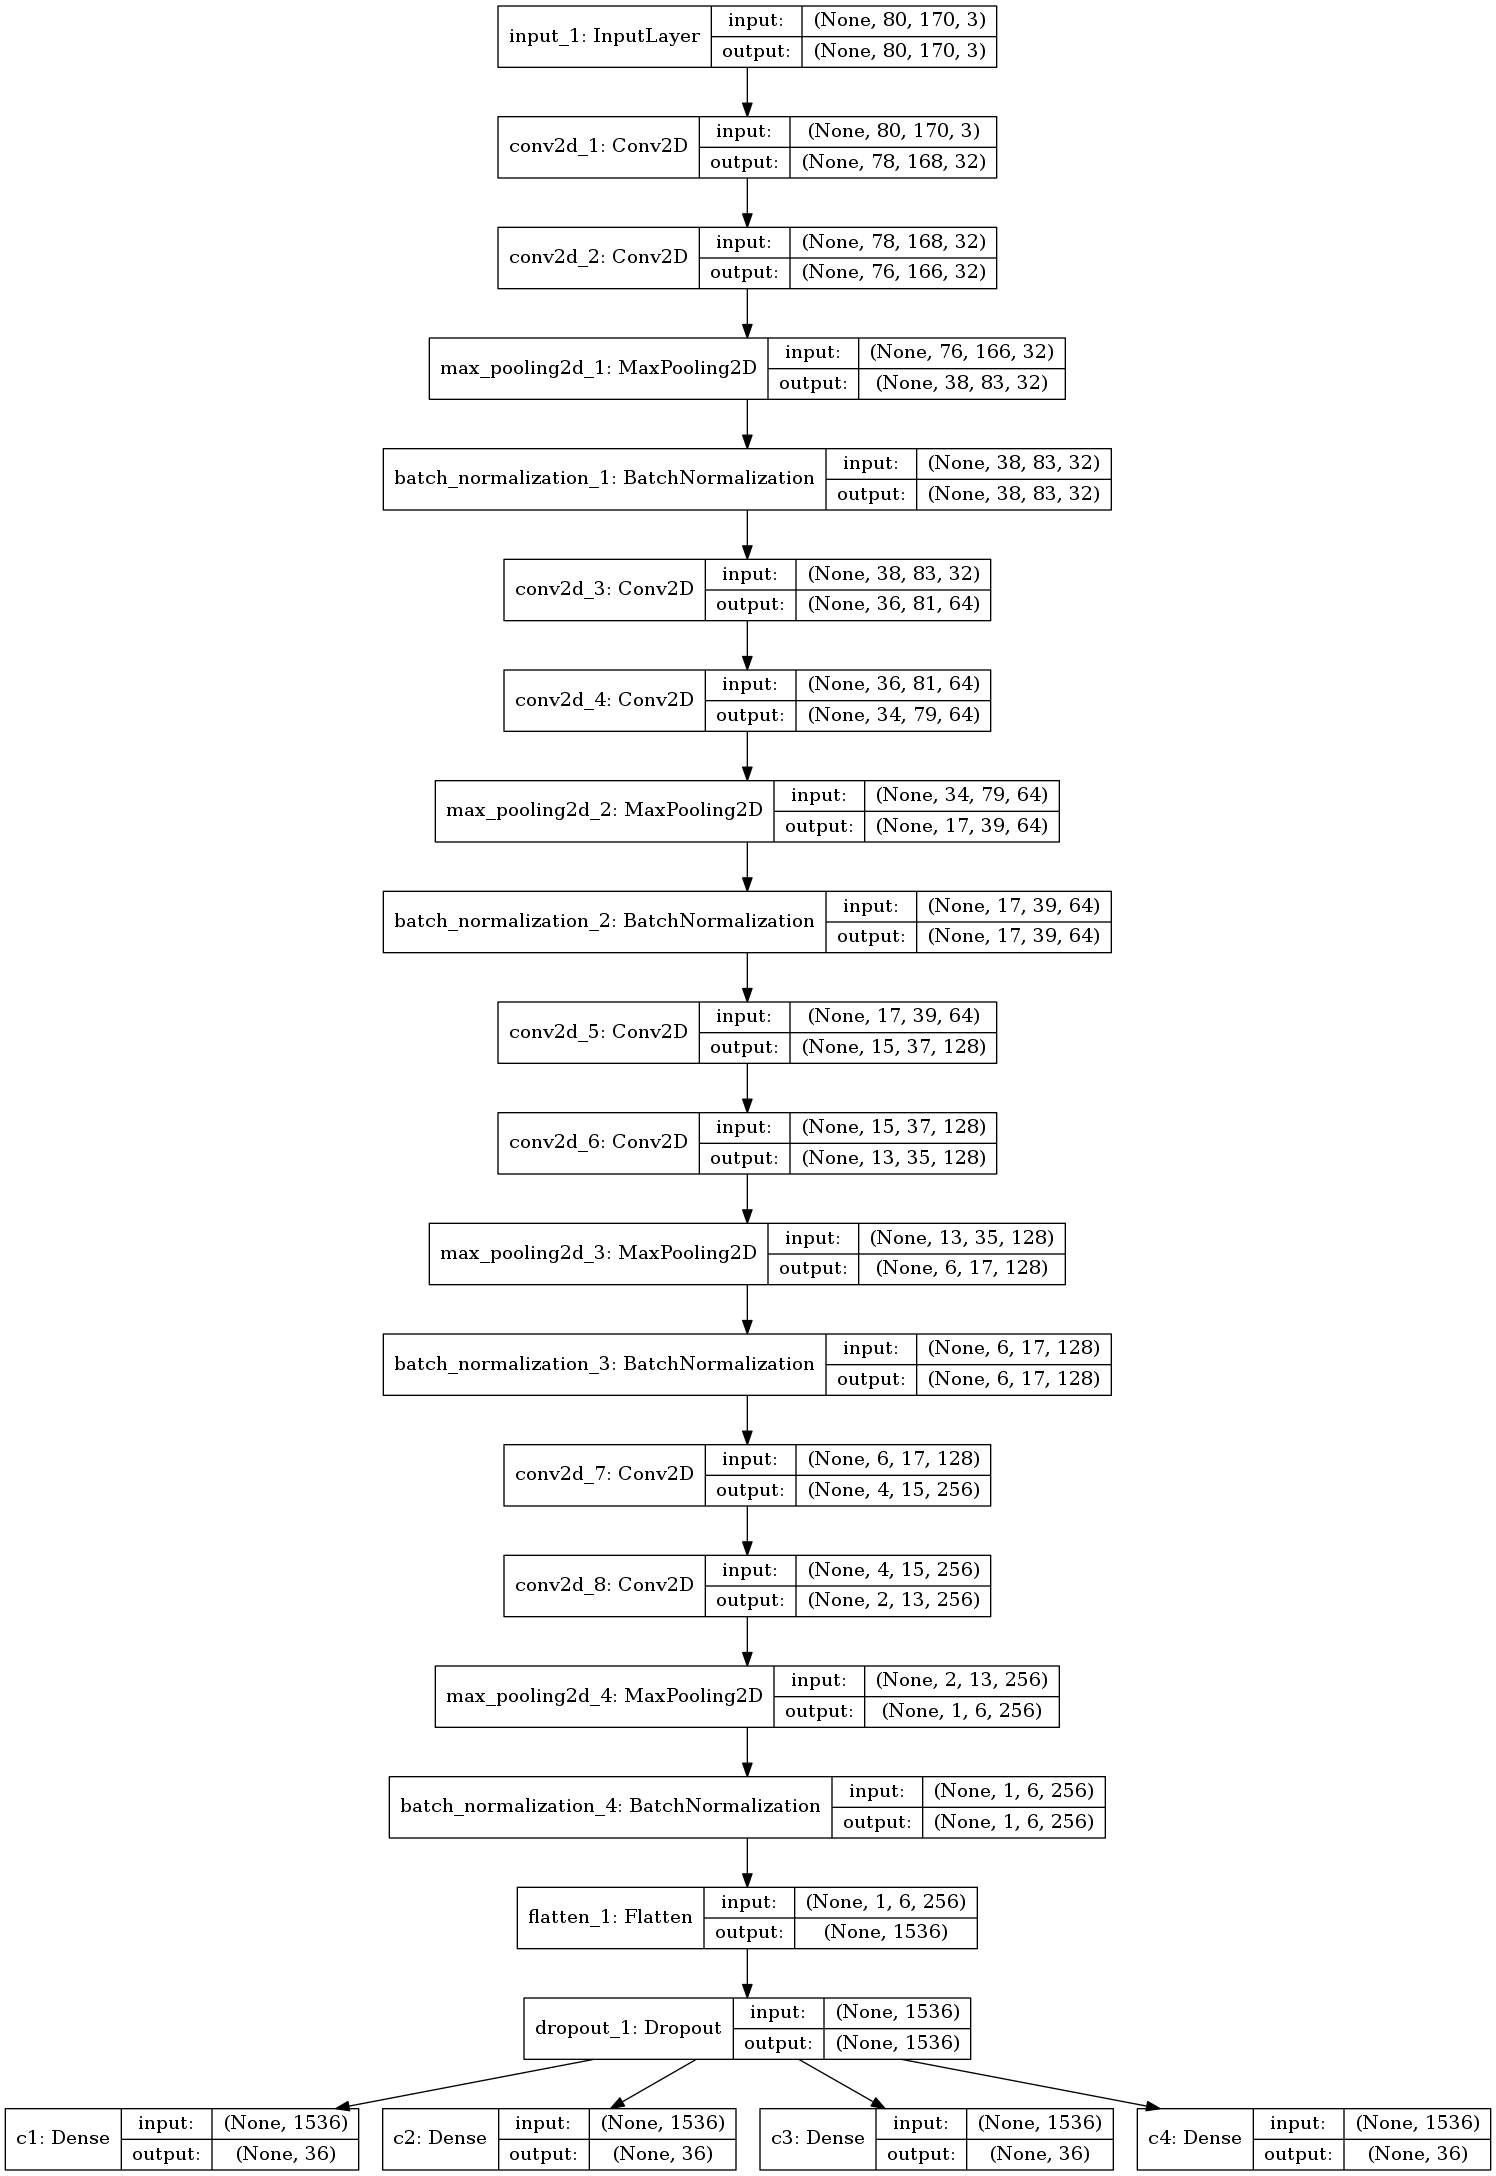

In [5]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="models/model_arch.png", show_shapes=True)
Image('models/model_arch.png')


## Train and save model

In [6]:
history = model.fit_generator(
                    gen(), 
                    steps_per_epoch=2560,#5120
                    epochs=10,
                    validation_data=gen(), 
                    validation_steps=1280
                   )

Epoch 1/10
2560/2560 [==============================] - 244s 95ms/step - loss: 2.5229 - c1_loss: 0.7638 - c2_loss: 0.5344 - c3_loss: 0.6503 - c4_loss: 0.5744 - c1_acc: 0.7956 - c2_acc: 0.8486 - c3_acc: 0.8185 - c4_acc: 0.8388 - val_loss: 7.9546 - val_c1_loss: 1.7695 - val_c2_loss: 1.9526 - val_c3_loss: 2.0758 - val_c4_loss: 2.1567 - val_c1_acc: 0.5436 - val_c2_acc: 0.5428 - val_c3_acc: 0.4880 - val_c4_acc: 0.5117
Epoch 2/10
2560/2560 [==============================] - 241s 94ms/step - loss: 0.3560 - c1_loss: 0.0671 - c2_loss: 0.0687 - c3_loss: 0.1296 - c4_loss: 0.0907 - c1_acc: 0.9779 - c2_acc: 0.9770 - c3_acc: 0.9602 - c4_acc: 0.9707 - val_loss: 2.3421 - val_c1_loss: 0.4607 - val_c2_loss: 0.5650 - val_c3_loss: 0.5823 - val_c4_loss: 0.7342 - val_c1_acc: 0.8938 - val_c2_acc: 0.8722 - val_c3_acc: 0.8566 - val_c4_acc: 0.8303
Epoch 3/10
2560/2560 [==============================] - 241s 94ms/step - loss: 0.2554 - c1_loss: 0.0476 - c2_loss: 0.0504 - c3_loss: 0.0909 - c4_loss: 0.0665 - c1_acc

In [7]:
model.save('models/captcha_model_weight.h5')

model_arch = model.to_yaml()
with open("models/captcha_model_structure.yaml", "w") as text_file:
    text_file.write(model_arch)

## Test a random generated captcha

(-0.5, 169.5, 79.5, -0.5)

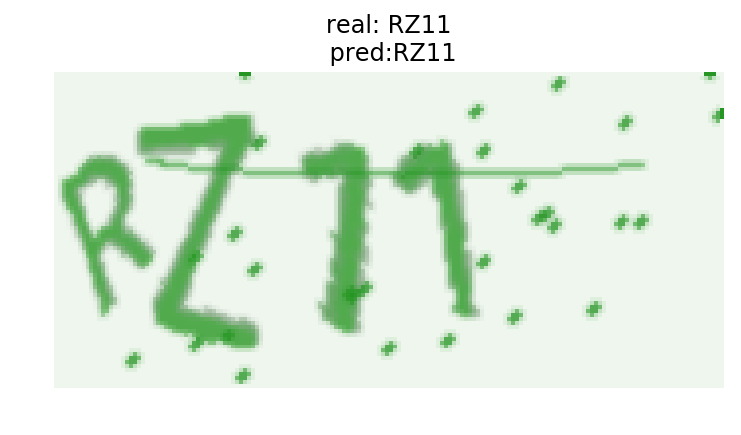

In [8]:
X, y = next(gen(1))
y_pred = model.predict(X)

plt.title('real: %s\n pred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')